### Uploading the CSV files

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys(): print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving train_bodies.csv to train_bodies.csv
Saving train_stances.csv to train_stances.csv
User uploaded file "train_bodies.csv" with length 3790028 bytes
User uploaded file "train_stances.csv" with length 4305273 bytes


### Reading from CSV

In [4]:
import pandas as pd
import numpy as np

df_train_stances = pd.read_csv('train_stances.csv')
df_train_bodies = pd.read_csv('train_bodies.csv')

stance = df_train_stances['Stance'].values
print(df_train_stances)
print(df_train_bodies)

                                                Headline  Body ID     Stance
0      Police find mass graves with at least '15 bodi...      712  unrelated
1      Hundreds of Palestinians flee floods in Gaza a...      158      agree
2      Christian Bale passes on role of Steve Jobs, a...      137  unrelated
3      HBO and Apple in Talks for $15/Month Apple TV ...     1034  unrelated
4      Spider burrowed through tourist's stomach and ...     1923   disagree
5      'Nasa Confirms Earth Will Experience 6 Days of...      154      agree
6      Accused Boston Marathon Bomber Severely Injure...      962  unrelated
7      Identity of ISIS terrorist known as 'Jihadi Jo...     2033  unrelated
8      Banksy 'Arrested & Real Identity Revealed' Is ...     1739      agree
9          British Aid Worker Confirmed Murdered By ISIS      882  unrelated
10                                        Gateway Pundit     2327    discuss
11     Woman detained in Lebanon is not al-Baghdadi's...     1468      agree

In [5]:
df_train_stances['Body ID'] = df_train_stances['Body ID'].map(df_train_bodies.set_index('Body ID')['articleBody'])
df_train_stances['text'] = df_train_stances['Headline'] + ' ' + df_train_stances['Body ID']

df_train_stances.head()

,Headline,Body ID,Stance,text
0,Police find mass graves with at least '15 bodi...,Danny Boyle is directing the untitled film\r\n...,unrelated,Police find mass graves with at least '15 bodi...
1,Hundreds of Palestinians flee floods in Gaza a...,Hundreds of Palestinians were evacuated from t...,agree,Hundreds of Palestinians flee floods in Gaza a...
2,"Christian Bale passes on role of Steve Jobs, a...",30-year-old Moscow resident was hospitalized w...,unrelated,"Christian Bale passes on role of Steve Jobs, a..."
3,HBO and Apple in Talks for $15/Month Apple TV ...,(Reuters) - A Canadian soldier was shot at the...,unrelated,HBO and Apple in Talks for $15/Month Apple TV ...
4,Spider burrowed through tourist's stomach and ...,"Fear not arachnophobes, the story of Bunbury's...",disagree,Spider burrowed through tourist's stomach and ...


['unrelated' 'agree' 'disagree' 'discuss']
36545 3678 840 8909


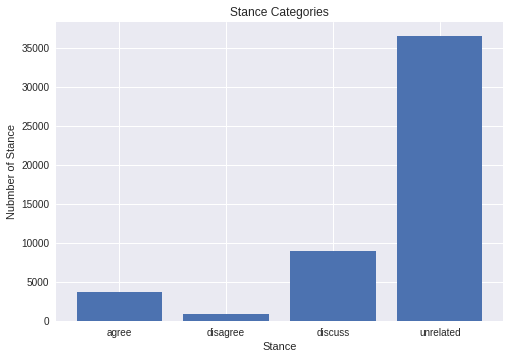

In [6]:
agree = 0
unrelated = 0
disagree = 0
discuss = 0

print(df_train_stances['Stance'].unique())

for stance in df_train_stances['Stance']:
  if stance == 'agree':
    agree += 1
  elif stance == 'disagree':
    disagree += 1
  elif stance == 'unrelated':
    unrelated += 1
  else:
    discuss += 1

print(unrelated, agree, disagree, discuss)

import matplotlib.pyplot as plt

categories = ['unrelated', 'agree', 'disagree', 'discuss']
index = np.arange(len(categories))
values = [36545, 3678, 840, 8909]

plt.bar(categories, values)
plt.title('Stance Categories')
plt.xlabel('Stance')
plt.ylabel('Nubmber of Stance')
plt.show()

## Preprocessing

In [6]:
!pip install -q inflect
!pip install progressbar2
import inflect
import re, string, unicodedata
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
import progressbar

text = df_train_stances['text'].values

def remove_non_ascii(words):
  """Remove non-ASCII characters from list of tokenized words"""
  str = ''
  for word in words:
    new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    str += new_word
  return str

def remove_punctuation(words):
  """Remove punctuation from list of tokenized words"""
  str = ''
  for word in words:
    new_word = re.sub(r'[^\w\s]', '', word)
    if new_word != '':
      str += new_word
  return str

def replace_numbers(words):
  """Replace all interger occurrences in list of tokenized words with textual representation"""
  p = inflect.engine()
  str = ''
  for word in words:
    if word.isdigit():
      new_word = p.number_to_words(word)
      str += new_word
    else:
      str += word
  return str

def stemming(words):
  str = ''
  stemmer = SnowballStemmer("english")

  for word in words:
    stem = stemmer.stem(word)
    str += stem
  return str

def normalize(words):
  words = remove_non_ascii(words)
  words = remove_punctuation(words)
  words = replace_numbers(words)
#   words = stemming(words)
  return words


In [7]:
normalized_text = []

for sentence in progressbar.progressbar(text):
  normalized_sentence = normalize(sentence)
  normalized_text.append(normalized_sentence)


100% (49972 of 49972) |##################| Elapsed Time: 0:04:04 Time:  0:04:04


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words='english', analyzer='word', lowercase=True, ngram_range=(2, 2))

text_count = count_vect.fit_transform(normalized_text)
print(text_count.shape)
# print(text_count)

(49972, 236304)


In [9]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

text_tfidf = tfidf_transformer.fit_transform(text_count)
print(text_tfidf.shape)
# print(text_tfidf)

(49972, 236304)


## Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(text_tfidf, stance, random_state=0, test_size=0.20)

# MultinomialNB

In [29]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train, y_train)

predicted = clf.predict(X_test)
# print(np.mean(predicted == stance))
print('Accuracy of MNB classifier on training set: {:.4f}' .format(clf.score(X_train, y_train)))
print('Accuracy of MNB classifier on test set: {:.4f}' .format(clf.score(X_test, y_test)))

Accuracy of MNB classifier on training set: 0.7937
Accuracy of MNB classifier on test set: 0.7711


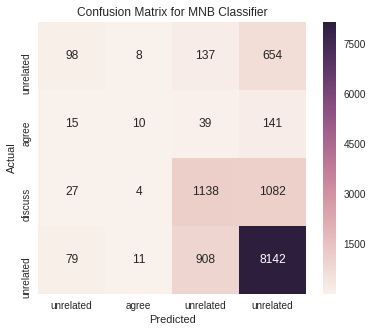

In [54]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_mat, annot = True, fmt = 'd', xticklabels = stance, yticklabels = stance)
plt.title('Confusion Matrix for MNB Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [56]:
from sklearn import metrics

print(metrics.classification_report(y_test, predicted, target_names = df_train_stances['Stance'].unique()))
print('Confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

             precision    recall  f1-score   support

  unrelated       0.45      0.11      0.18       897
      agree       0.30      0.05      0.08       205
   disagree       0.51      0.51      0.51      2251
    discuss       0.81      0.89      0.85      9140

avg / total       0.72      0.75      0.73     12493

Confusion matrix
[[  98    8  137  654]
 [  15   10   39  141]
 [  27    4 1138 1082]
 [  79   11  908 8142]]


# Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train, y_train)

predicted = logreg.predict(X_test)
print('Accuracy of Logistic regression classifier on training set: {:.4f}' .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.4f}' .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.8285
Accuracy of Logistic regression classifier on test set: 0.8113


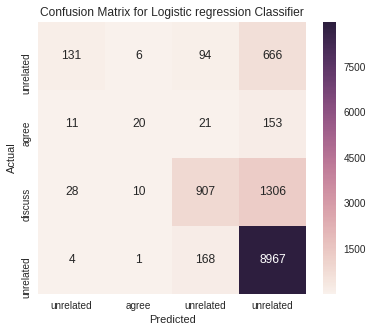

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_mat, annot = True, fmt = 'd', xticklabels = stance, yticklabels = stance)
plt.title('Confusion Matrix for Logistic regression Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [39]:
from sklearn import metrics

print(metrics.classification_report(y_test, predicted, target_names = df_train_stances['Stance'].unique()))

             precision    recall  f1-score   support

  unrelated       0.75      0.15      0.24       897
      agree       0.54      0.10      0.17       205
   disagree       0.76      0.40      0.53      2251
    discuss       0.81      0.98      0.89      9140

avg / total       0.79      0.80      0.76     12493



# SVM

In [15]:
from sklearn import svm

svc = svm.SVC(kernel = 'linear', C = 1.0).fit(X_train, y_train)

print('Accuracy of SVM on training set: {:.4f}' .format(svc.score(X_train, y_train)))
print('Accuracy of SVM on test set: {:.4f}' .format(svc.score(X_test, y_test)))

Accuracy of SVM on training set: 0.8339
Accuracy of SVM on test set: 0.8170


# Stochastic Gradient Descent

In [48]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='perceptron', penalty='l2', n_jobs=-1, max_iter=1000, warm_start=True, verbose=True).fit(X_train, y_train)

print('Accuracy of SGD on training set: {:.4f}' .format(sgd.score(X_train, y_train)))
print('Accuracy of SGD on test set: {:.4f}' .format(sgd.score(X_test, y_test)))

-- Epoch 1-- Epoch 1

Norm: 7.03, NNZs: 117227, Bias: -0.096198, T: 37479, Avg. loss: 0.035656
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 3.51, NNZs: 41748, Bias: -0.241342, T: 37479, Avg. loss: 0.010221
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 4.81, NNZs: 120790, Bias: -0.067266, T: 74958, Avg. loss: 0.006577
Total training time: 0.11 seconds.
-- Epoch 3
Norm: 2.56, NNZs: 42860, Bias: -0.161676, T: 74958, Avg. loss: 0.001836
Total training time: 0.12 seconds.
-- Epoch 3
Norm: 3.94, NNZs: 122295, Bias: -0.057369, T: 112437, Avg. loss: 0.003496
Total training time: 0.16 seconds.
-- Epoch 4
Norm: 2.14, NNZs: 43578, Bias: -0.117589, T: 112437, Avg. loss: 0.001016
Total training time: 0.18 seconds.
-- Epoch 4
Norm: 3.41, NNZs: 123261, Bias: -0.045835, T: 149916, Avg. loss: 0.002285
Total training time: 0.21 seconds.
-- Epoch 5
Norm: 1.88, NNZs: 44211, Bias: -0.099122, T: 149916, Avg. loss: 0.000650
Total training time: 0.24 seconds.
-- Epoch 5
Norm: 3.04, NNZs: 124186, 

Norm: 0.59, NNZs: 47460, Bias: -0.023839, T: 1724034, Avg. loss: 0.000019
Total training time: 3.06 seconds.
-- Epoch 47
Norm: 0.89, NNZs: 131477, Bias: -0.005385, T: 2023866, Avg. loss: 0.000037
Total training time: 3.09 seconds.
-- Epoch 55
Norm: 0.58, NNZs: 47472, Bias: -0.024181, T: 1761513, Avg. loss: 0.000017
Total training time: 3.14 seconds.
-- Epoch 48
Norm: 0.89, NNZs: 131487, Bias: -0.005237, T: 2061345, Avg. loss: 0.000037
Total training time: 3.17 seconds.
-- Epoch 56
Norm: 0.58, NNZs: 47486, Bias: -0.023281, T: 1798992, Avg. loss: 0.000018
Total training time: 3.21 seconds.
-- Epoch 49
Norm: 0.88, NNZs: 131501, Bias: -0.004853, T: 2098824, Avg. loss: 0.000036
Total training time: 3.25 seconds.
-- Epoch 57
Norm: 0.57, NNZs: 47487, Bias: -0.023171, T: 1836471, Avg. loss: 0.000016
Total training time: 3.29 seconds.
-- Epoch 50
Norm: 0.87, NNZs: 131505, Bias: -0.005185, T: 2136303, Avg. loss: 0.000035
Total training time: 3.34 seconds.
-- Epoch 58
Norm: 0.57, NNZs: 47488, Bia

Norm: 0.39, NNZs: 47536, Bias: -0.015214, T: 3523026, Avg. loss: 0.000005
Total training time: 6.77 seconds.
-- Epoch 95
Norm: 0.61, NNZs: 132434, Bias: -0.003049, T: 3710421, Avg. loss: 0.000011
Total training time: 6.79 seconds.
-- Epoch 100
Norm: 0.39, NNZs: 47536, Bias: -0.015243, T: 3560505, Avg. loss: 0.000004
Total training time: 6.84 seconds.
-- Epoch 96
Norm: 0.61, NNZs: 132434, Bias: -0.003022, T: 3747900, Avg. loss: 0.000011
Total training time: 6.87 seconds.
-- Epoch 101
Norm: 0.38, NNZs: 47537, Bias: -0.015020, T: 3597984, Avg. loss: 0.000005
Total training time: 6.91 seconds.
-- Epoch 97
Norm: 0.60, NNZs: 132436, Bias: -0.002890, T: 3785379, Avg. loss: 0.000011
Total training time: 6.94 seconds.
-- Epoch 102
Norm: 0.38, NNZs: 47537, Bias: -0.015103, T: 3635463, Avg. loss: 0.000005
Total training time: 6.99 seconds.
-- Epoch 98
Norm: 0.60, NNZs: 132438, Bias: -0.002891, T: 3822858, Avg. loss: 0.000010
Total training time: 7.03 seconds.
-- Epoch 103
Norm: 0.38, NNZs: 47537,

Norm: 0.47, NNZs: 132705, Bias: -0.002132, T: 5396976, Avg. loss: 0.000005
Total training time: 10.47 seconds.
-- Epoch 145
Norm: 0.30, NNZs: 47558, Bias: -0.011797, T: 5322018, Avg. loss: 0.000003
Total training time: 10.47 seconds.
-- Epoch 143
Norm: 0.46, NNZs: 132706, Bias: -0.002114, T: 5434455, Avg. loss: 0.000005
Total training time: 10.55 seconds.
Norm: 0.30, NNZs: 47558, Bias: -0.011779, T: 5359497, Avg. loss: 0.000003
Total training time: 10.55 seconds.
-- Epoch 146
-- Epoch 144
Norm: 0.30, NNZs: 47558, Bias: -0.011723, T: 5396976, Avg. loss: 0.000003
Total training time: 10.63 seconds.
-- Epoch 145
Norm: 0.46, NNZs: 132722, Bias: -0.002187, T: 5471934, Avg. loss: 0.000005
Total training time: 10.63 seconds.
-- Epoch 147
Norm: 0.46, NNZs: 132722, Bias: -0.002096, T: 5509413, Avg. loss: 0.000005
Total training time: 10.72 seconds.
Norm: 0.29, NNZs: 47558, Bias: -0.011612, T: 5434455, Avg. loss: 0.000003
-- Epoch 148Total training time: 10.72 seconds.

-- Epoch 146
Norm: 0.29, 

Norm: 0.25, NNZs: 47562, Bias: -0.009814, T: 7121010, Avg. loss: 0.000002
Total training time: 14.21 seconds.
Norm: 0.38, NNZs: 133878, Bias: -0.001665, T: 7121010, Avg. loss: 0.000003
Total training time: 14.22 seconds.-- Epoch 191

-- Epoch 191
Norm: 0.25, NNZs: 47562, Bias: -0.009856, T: 7158489, Avg. loss: 0.000002
Total training time: 14.29 seconds.
-- Epoch 192
Norm: 0.37, NNZs: 133935, Bias: -0.001623, T: 7158489, Avg. loss: 0.000003
Total training time: 14.30 seconds.
-- Epoch 192
Norm: 0.24, NNZs: 47562, Bias: -0.009786, T: 7195968, Avg. loss: 0.000002
Total training time: 14.37 seconds.
-- Epoch 193
Norm: 0.37, NNZs: 133937, Bias: -0.001637, T: 7195968, Avg. loss: 0.000002
Total training time: 14.38 seconds.
-- Epoch 193
Norm: 0.24, NNZs: 47562, Bias: -0.009772, T: 7233447, Avg. loss: 0.000002
Total training time: 14.45 seconds.
-- Epoch 194
Norm: 0.37, NNZs: 133937, Bias: -0.001665, T: 7233447, Avg. loss: 0.000003
Total training time: 14.47 seconds.
-- Epoch 194
Norm: 0.24, 

Norm: 0.31, NNZs: 133954, Bias: -0.001421, T: 8845044, Avg. loss: 0.000002
Total training time: 17.97 seconds.
-- Epoch 237
Norm: 0.21, NNZs: 47562, Bias: -0.008598, T: 8920002, Avg. loss: 0.000001
Total training time: 17.98 seconds.
-- Epoch 239
Norm: 0.31, NNZs: 133954, Bias: -0.001376, T: 8882523, Avg. loss: 0.000002
Total training time: 18.05 seconds.
-- Epoch 238
Norm: 0.21, NNZs: 47562, Bias: -0.008531, T: 8957481, Avg. loss: 0.000001
Total training time: 18.06 seconds.
-- Epoch 240
Norm: 0.31, NNZs: 133955, Bias: -0.001365, T: 8920002, Avg. loss: 0.000002
Total training time: 18.13 seconds.
-- Epoch 239
Norm: 0.21, NNZs: 47562, Bias: -0.008531, T: 8994960, Avg. loss: 0.000001
Total training time: 18.13 seconds.
-- Epoch 241
Norm: 0.21, NNZs: 47562, Bias: -0.008509, T: 9032439, Avg. loss: 0.000001
Total training time: 18.21 seconds.
Norm: 0.31, NNZs: 133955, Bias: -0.001387, T: 8957481, Avg. loss: 0.000002
Total training time: 18.21 seconds.
-- Epoch 242
-- Epoch 240
Norm: 0.21, 

Norm: 0.27, NNZs: 134185, Bias: -0.001171, T: 10569078, Avg. loss: 0.000001
Total training time: 21.74 seconds.
-- Epoch 283
Norm: 0.18, NNZs: 47562, Bias: -0.007623, T: 10718994, Avg. loss: 0.000001
Total training time: 21.76 seconds.
-- Epoch 287
Norm: 0.27, NNZs: 134185, Bias: -0.001171, T: 10606557, Avg. loss: 0.000001
Total training time: 21.82 seconds.
-- Epoch 284
Norm: 0.18, NNZs: 47562, Bias: -0.007623, T: 10756473, Avg. loss: 0.000001
Total training time: 21.85 seconds.
-- Epoch 288
Norm: 0.27, NNZs: 134185, Bias: -0.001171, T: 10644036, Avg. loss: 0.000001
Total training time: 21.89 seconds.
-- Epoch 285
Norm: 0.18, NNZs: 47562, Bias: -0.007614, T: 10793952, Avg. loss: 0.000001
Total training time: 21.92 seconds.
-- Epoch 289
Norm: 0.27, NNZs: 134185, Bias: -0.001171, T: 10681515, Avg. loss: 0.000001
Total training time: 21.98 seconds.
-- Epoch 286
Norm: 0.18, NNZs: 47562, Bias: -0.007559, T: 10831431, Avg. loss: 0.000001
Total training time: 22.00 seconds.
-- Epoch 290
Norm

Norm: 0.24, NNZs: 134263, Bias: -0.000990, T: 12218154, Avg. loss: 0.000001
Total training time: 25.29 seconds.
-- Epoch 327
Norm: 0.17, NNZs: 47565, Bias: -0.006949, T: 12405549, Avg. loss: 0.000001
Total training time: 25.31 seconds.
-- Epoch 332
Norm: 0.24, NNZs: 134263, Bias: -0.001014, T: 12255633, Avg. loss: 0.000001
Total training time: 25.37 seconds.
-- Epoch 328
Norm: 0.17, NNZs: 47565, Bias: -0.006965, T: 12443028, Avg. loss: 0.000001
Total training time: 25.40 seconds.
-- Epoch 333
Norm: 0.24, NNZs: 134263, Bias: -0.001023, T: 12293112, Avg. loss: 0.000001
Total training time: 25.45 seconds.
-- Epoch 329
Norm: 0.16, NNZs: 47565, Bias: -0.006941, T: 12480507, Avg. loss: 0.000001
Total training time: 25.47 seconds.
-- Epoch 334
Norm: 0.24, NNZs: 134263, Bias: -0.001039, T: 12330591, Avg. loss: 0.000001
Total training time: 25.53 seconds.
-- Epoch 330
Norm: 0.16, NNZs: 47565, Bias: -0.006909, T: 12517986, Avg. loss: 0.000001
Total training time: 25.55 seconds.
-- Epoch 335
Norm

Norm: 0.15, NNZs: 47566, Bias: -0.006428, T: 14092104, Avg. loss: 0.000001
Total training time: 28.87 seconds.
-- Epoch 377
Norm: 0.22, NNZs: 134268, Bias: -0.000938, T: 13904709, Avg. loss: 0.000001
Total training time: 28.91 seconds.
-- Epoch 372
Norm: 0.15, NNZs: 47566, Bias: -0.006379, T: 14129583, Avg. loss: 0.000001
Total training time: 28.95 seconds.
-- Epoch 378
Norm: 0.22, NNZs: 134268, Bias: -0.000909, T: 13942188, Avg. loss: 0.000001
Total training time: 28.99 seconds.
-- Epoch 373
Norm: 0.15, NNZs: 47566, Bias: -0.006400, T: 14167062, Avg. loss: 0.000001
Total training time: 29.02 seconds.
-- Epoch 379
Norm: 0.22, NNZs: 134268, Bias: -0.000902, T: 13979667, Avg. loss: 0.000001
Total training time: 29.07 seconds.
-- Epoch 374
Norm: 0.15, NNZs: 47566, Bias: -0.006400, T: 14204541, Avg. loss: 0.000001
Total training time: 29.10 seconds.
-- Epoch 380
Norm: 0.22, NNZs: 134268, Bias: -0.000910, T: 14017146, Avg. loss: 0.000001
Total training time: 29.15 seconds.
-- Epoch 375
Norm

Norm: 0.14, NNZs: 47566, Bias: -0.005949, T: 15891096, Avg. loss: 0.000001Norm: 0.20, NNZs: 134276, Bias: -0.000829, T: 15628743, Avg. loss: 0.000001
Total training time: 32.60 seconds.

Total training time: 32.59 seconds.
-- Epoch 418
-- Epoch 425
Norm: 0.14, NNZs: 47566, Bias: -0.005936, T: 15928575, Avg. loss: 0.000001
Norm: 0.20, NNZs: 134276, Bias: -0.000816, T: 15666222, Avg. loss: 0.000001
Total training time: 32.68 seconds.Total training time: 32.68 seconds.

-- Epoch 419
-- Epoch 426
Norm: 0.14, NNZs: 47566, Bias: -0.005961, T: 15966054, Avg. loss: 0.000001
Total training time: 32.76 seconds.
Norm: 0.20, NNZs: 134276, Bias: -0.000835, T: 15703701, Avg. loss: 0.000001
Total training time: 32.76 seconds.
-- Epoch 427
-- Epoch 420
Norm: 0.14, NNZs: 47566, Bias: -0.005936, T: 16003533, Avg. loss: 0.000001
Total training time: 32.84 seconds.
-- Epoch 428
Norm: 0.20, NNZs: 134276, Bias: -0.000816, T: 15741180, Avg. loss: 0.000001
Total training time: 32.84 seconds.
-- Epoch 421
Norm

Norm: 0.18, NNZs: 134282, Bias: -0.000733, T: 17277819, Avg. loss: 0.000001
Total training time: 36.13 seconds.
-- Epoch 462
Norm: 0.13, NNZs: 47566, Bias: -0.005608, T: 17577651, Avg. loss: 0.000001
Total training time: 36.15 seconds.
-- Epoch 470
Norm: 0.18, NNZs: 134282, Bias: -0.000762, T: 17315298, Avg. loss: 0.000001
Total training time: 36.20 seconds.
-- Epoch 463
Norm: 0.13, NNZs: 47566, Bias: -0.005608, T: 17615130, Avg. loss: 0.000001
Total training time: 36.23 seconds.
-- Epoch 471
Norm: 0.18, NNZs: 134411, Bias: -0.000739, T: 17352777, Avg. loss: 0.000001
Total training time: 36.29 seconds.
-- Epoch 464
Norm: 0.13, NNZs: 47566, Bias: -0.005586, T: 17652609, Avg. loss: 0.000001
Total training time: 36.30 seconds.
-- Epoch 472
Norm: 0.18, NNZs: 134411, Bias: -0.000744, T: 17390256, Avg. loss: 0.000001
Total training time: 36.37 seconds.
-- Epoch 465
Norm: 0.13, NNZs: 47566, Bias: -0.005563, T: 17690088, Avg. loss: 0.000001
Total training time: 36.39 seconds.
-- Epoch 473
Norm

Norm: 0.12, NNZs: 47566, Bias: -0.005287, T: 19301685, Avg. loss: 0.000000
Total training time: 39.87 seconds.
-- Epoch 516
Norm: 0.17, NNZs: 134470, Bias: -0.000673, T: 19076811, Avg. loss: 0.000001
Total training time: 39.89 seconds.
-- Epoch 510
Norm: 0.12, NNZs: 47566, Bias: -0.005282, T: 19339164, Avg. loss: 0.000001
Total training time: 39.95 seconds.
-- Epoch 517
Norm: 0.17, NNZs: 134470, Bias: -0.000694, T: 19114290, Avg. loss: 0.000001
Total training time: 39.96 seconds.
-- Epoch 511
Norm: 0.12, NNZs: 47566, Bias: -0.005272, T: 19376643, Avg. loss: 0.000000
Total training time: 40.02 seconds.
-- Epoch 518
Norm: 0.17, NNZs: 134470, Bias: -0.000668, T: 19151769, Avg. loss: 0.000001
Total training time: 40.04 seconds.
-- Epoch 512
Norm: 0.12, NNZs: 47566, Bias: -0.005251, T: 19414122, Avg. loss: 0.000001
Total training time: 40.11 seconds.
-- Epoch 519
Norm: 0.17, NNZs: 134470, Bias: -0.000668, T: 19189248, Avg. loss: 0.000001
Total training time: 40.12 seconds.
-- Epoch 513
Norm

Norm: 0.11, NNZs: 47567, Bias: -0.005009, T: 20913282, Avg. loss: 0.000000
Total training time: 43.38 seconds.
-- Epoch 559
Norm: 0.16, NNZs: 134474, Bias: -0.000609, T: 20763366, Avg. loss: 0.000001
Total training time: 43.39 seconds.
-- Epoch 555
Norm: 0.11, NNZs: 47567, Bias: -0.005009, T: 20950761, Avg. loss: 0.000000
Total training time: 43.45 seconds.
-- Epoch 560
Norm: 0.15, NNZs: 134474, Bias: -0.000624, T: 20800845, Avg. loss: 0.000001
Total training time: 43.47 seconds.
-- Epoch 556
Norm: 0.11, NNZs: 47567, Bias: -0.005033, T: 20988240, Avg. loss: 0.000000
Total training time: 43.53 seconds.
-- Epoch 561
Norm: 0.15, NNZs: 134474, Bias: -0.000633, T: 20838324, Avg. loss: 0.000001
Total training time: 43.54 seconds.
-- Epoch 557
Norm: 0.11, NNZs: 47567, Bias: -0.005014, T: 21025719, Avg. loss: 0.000000
Total training time: 43.62 seconds.
Norm: 0.15, NNZs: 134474, Bias: -0.000629, T: 20875803, Avg. loss: 0.000001
Total training time: 43.62 seconds.
-- Epoch 562
-- Epoch 558
Norm

Norm: 0.14, NNZs: 134482, Bias: -0.000583, T: 22524879, Avg. loss: 0.000001
Total training time: 47.07 seconds.
-- Epoch 602
Norm: 0.11, NNZs: 47567, Bias: -0.004789, T: 22637316, Avg. loss: 0.000000
Total training time: 47.11 seconds.
-- Epoch 605
Norm: 0.14, NNZs: 134482, Bias: -0.000583, T: 22562358, Avg. loss: 0.000001
Total training time: 47.16 seconds.
-- Epoch 603
Norm: 0.10, NNZs: 47567, Bias: -0.004793, T: 22674795, Avg. loss: 0.000001
Total training time: 47.19 seconds.
-- Epoch 606
Norm: 0.14, NNZs: 134482, Bias: -0.000605, T: 22599837, Avg. loss: 0.000001
Total training time: 47.24 seconds.
-- Epoch 604
Norm: 0.10, NNZs: 47567, Bias: -0.004780, T: 22712274, Avg. loss: 0.000000
Total training time: 47.27 seconds.
-- Epoch 607
Norm: 0.14, NNZs: 134482, Bias: -0.000600, T: 22637316, Avg. loss: 0.000001
Total training time: 47.32 seconds.
-- Epoch 605
Norm: 0.10, NNZs: 47567, Bias: -0.004780, T: 22749753, Avg. loss: 0.000000
Total training time: 47.35 seconds.
-- Epoch 608
Norm

Norm: 0.10, NNZs: 47567, Bias: -0.004588, T: 24248913, Avg. loss: 0.000000
Total training time: 50.59 seconds.
-- Epoch 648
Norm: 0.14, NNZs: 134484, Bias: -0.000540, T: 24211434, Avg. loss: 0.000001
Total training time: 50.62 seconds.
-- Epoch 647
Norm: 0.10, NNZs: 47567, Bias: -0.004563, T: 24286392, Avg. loss: 0.000000
Total training time: 50.67 seconds.
-- Epoch 649
Norm: 0.14, NNZs: 134484, Bias: -0.000561, T: 24248913, Avg. loss: 0.000001
Total training time: 50.70 seconds.
-- Epoch 648
Norm: 0.10, NNZs: 47567, Bias: -0.004588, T: 24323871, Avg. loss: 0.000000
Total training time: 50.74 seconds.
-- Epoch 650
Norm: 0.14, NNZs: 134484, Bias: -0.000540, T: 24286392, Avg. loss: 0.000001
Total training time: 50.78 seconds.
-- Epoch 649
Norm: 0.10, NNZs: 47567, Bias: -0.004572, T: 24361350, Avg. loss: 0.000000
Total training time: 50.82 seconds.
-- Epoch 651
Norm: 0.14, NNZs: 134484, Bias: -0.000540, T: 24323871, Avg. loss: 0.000001
Total training time: 50.87 seconds.
-- Epoch 650
Norm

Norm: 0.13, NNZs: 134573, Bias: -0.000497, T: 25897989, Avg. loss: 0.000000
Total training time: 54.30 seconds.
-- Epoch 692
Norm: 0.09, NNZs: 47567, Bias: -0.004381, T: 26047905, Avg. loss: 0.000000
Total training time: 54.31 seconds.
-- Epoch 696
Norm: 0.13, NNZs: 134573, Bias: -0.000497, T: 25935468, Avg. loss: 0.000000
Total training time: 54.38 seconds.
-- Epoch 693
Norm: 0.09, NNZs: 47567, Bias: -0.004381, T: 26085384, Avg. loss: 0.000000
Total training time: 54.38 seconds.
-- Epoch 697
Norm: 0.13, NNZs: 134573, Bias: -0.000505, T: 25972947, Avg. loss: 0.000000
Total training time: 54.46 seconds.
Norm: 0.09, NNZs: 47567, Bias: -0.004374, T: 26122863, Avg. loss: 0.000000
Total training time: 54.46 seconds.
-- Epoch 694-- Epoch 698

Norm: 0.09, NNZs: 47567, Bias: -0.004377, T: 26160342, Avg. loss: 0.000000
Total training time: 54.55 seconds.
-- Epoch 699
Norm: 0.13, NNZs: 134573, Bias: -0.000524, T: 26010426, Avg. loss: 0.000000
Total training time: 54.56 seconds.
-- Epoch 695
Norm

Norm: 0.09, NNZs: 47567, Bias: -0.004211, T: 27771939, Avg. loss: 0.000000
Total training time: 58.01 seconds.
-- Epoch 742
Norm: 0.12, NNZs: 134701, Bias: -0.000479, T: 27659502, Avg. loss: 0.000000
Total training time: 58.02 seconds.
-- Epoch 739
Norm: 0.09, NNZs: 47567, Bias: -0.004214, T: 27809418, Avg. loss: 0.000000
Total training time: 58.08 seconds.
-- Epoch 743
Norm: 0.12, NNZs: 134701, Bias: -0.000468, T: 27696981, Avg. loss: 0.000000
Total training time: 58.10 seconds.
-- Epoch 740
Norm: 0.09, NNZs: 47567, Bias: -0.004218, T: 27846897, Avg. loss: 0.000000
Total training time: 58.16 seconds.
-- Epoch 744
Norm: 0.12, NNZs: 134701, Bias: -0.000471, T: 27734460, Avg. loss: 0.000000
Total training time: 58.17 seconds.
-- Epoch 741
Norm: 0.09, NNZs: 47567, Bias: -0.004200, T: 27884376, Avg. loss: 0.000000
Total training time: 58.24 seconds.
-- Epoch 745
Norm: 0.12, NNZs: 134701, Bias: -0.000479, T: 27771939, Avg. loss: 0.000000
Total training time: 58.26 seconds.
-- Epoch 742
Norm


Norm: 0.09, NNZs: 47567, Bias: -0.004074, T: 29458494, Avg. loss: 0.000000
Total training time: 61.52 seconds.
-- Epoch 787
Norm: 0.11, NNZs: 134704, Bias: -0.000447, T: 29308578, Avg. loss: 0.000000
Total training time: 61.57 seconds.
-- Epoch 783
Norm: 0.09, NNZs: 47567, Bias: -0.004061, T: 29495973, Avg. loss: 0.000000
Total training time: 61.60 seconds.
-- Epoch 788
Norm: 0.11, NNZs: 134705, Bias: -0.000444, T: 29346057, Avg. loss: 0.000000
Total training time: 61.65 seconds.
-- Epoch 784
Norm: 0.09, NNZs: 47567, Bias: -0.004071, T: 29533452, Avg. loss: 0.000000
Total training time: 61.67 seconds.
-- Epoch 789
Norm: 0.11, NNZs: 134705, Bias: -0.000440, T: 29383536, Avg. loss: 0.000000
Total training time: 61.73 seconds.
-- Epoch 785
Norm: 0.09, NNZs: 47567, Bias: -0.004071, T: 29570931, Avg. loss: 0.000000
Total training time: 61.75 seconds.
-- Epoch 790
Norm: 0.11, NNZs: 134705, Bias: -0.000447, T: 29421015, Avg. loss: 0.000000
Total training time: 61.80 seconds.
-- Epoch 786
Nor

Norm: 0.11, NNZs: 134708, Bias: -0.000424, T: 31032612, Avg. loss: 0.000000
Total training time: 65.22 seconds.
-- Epoch 829
Norm: 0.08, NNZs: 47567, Bias: -0.003919, T: 31220007, Avg. loss: 0.000000
Total training time: 65.22 seconds.
-- Epoch 834
Norm: 0.08, NNZs: 47567, Bias: -0.003932, T: 31257486, Avg. loss: 0.000000
Total training time: 65.30 seconds.
Norm: 0.11, NNZs: 134708, Bias: -0.000431, T: 31070091, Avg. loss: 0.000000
Total training time: 65.30 seconds.
-- Epoch 835
-- Epoch 830
Norm: 0.11, NNZs: 134708, Bias: -0.000418, T: 31107570, Avg. loss: 0.000000
Total training time: 65.38 seconds.
-- Epoch 831
Norm: 0.08, NNZs: 47567, Bias: -0.003919, T: 31294965, Avg. loss: 0.000000
Total training time: 65.39 seconds.
-- Epoch 836
Norm: 0.11, NNZs: 134708, Bias: -0.000427, T: 31145049, Avg. loss: 0.000000
Total training time: 65.47 seconds.
Norm: 0.08, NNZs: 47567, Bias: -0.003916, T: 31332444, Avg. loss: 0.000000
Total training time: 65.47 seconds.
-- Epoch 832
-- Epoch 837
Norm

Norm: 0.10, NNZs: 134709, Bias: -0.000399, T: 32681688, Avg. loss: 0.000000
Total training time: 68.78 seconds.
-- Epoch 873
Norm: 0.08, NNZs: 47568, Bias: -0.003804, T: 32906562, Avg. loss: 0.000000
Total training time: 68.78 seconds.
-- Epoch 879
Norm: 0.10, NNZs: 134709, Bias: -0.000402, T: 32719167, Avg. loss: 0.000000
Total training time: 68.85 seconds.
-- Epoch 874
Norm: 0.08, NNZs: 47568, Bias: -0.003797, T: 32944041, Avg. loss: 0.000000
Total training time: 68.85 seconds.
-- Epoch 880
Norm: 0.10, NNZs: 134709, Bias: -0.000399, T: 32756646, Avg. loss: 0.000000Norm: 0.08, NNZs: 47568, Bias: -0.003794, T: 32981520, Avg. loss: 0.000000

Total training time: 68.93 seconds.
Total training time: 68.93 seconds.
-- Epoch 881
-- Epoch 875
Norm: 0.08, NNZs: 47568, Bias: -0.003785, T: 33018999, Avg. loss: 0.000000
Total training time: 69.01 seconds.
-- Epoch 882
Norm: 0.10, NNZs: 134709, Bias: -0.000408, T: 32794125, Avg. loss: 0.000000
Total training time: 69.02 seconds.
-- Epoch 876
Norm

Norm: 0.08, NNZs: 47568, Bias: -0.003682, T: 34705554, Avg. loss: 0.000000
Total training time: 72.52 seconds.
-- Epoch 927
Norm: 0.10, NNZs: 134709, Bias: -0.000370, T: 34405722, Avg. loss: 0.000000
Total training time: 72.55 seconds.
-- Epoch 919
Norm: 0.08, NNZs: 47568, Bias: -0.003679, T: 34743033, Avg. loss: 0.000000
Total training time: 72.60 seconds.
-- Epoch 928
Norm: 0.10, NNZs: 134709, Bias: -0.000376, T: 34443201, Avg. loss: 0.000000
Total training time: 72.63 seconds.
-- Epoch 920
Norm: 0.08, NNZs: 47568, Bias: -0.003673, T: 34780512, Avg. loss: 0.000000
Total training time: 72.67 seconds.
-- Epoch 929
Norm: 0.10, NNZs: 134709, Bias: -0.000387, T: 34480680, Avg. loss: 0.000000
Total training time: 72.71 seconds.
-- Epoch 921
Norm: 0.08, NNZs: 47568, Bias: -0.003665, T: 34817991, Avg. loss: 0.000000
Total training time: 72.75 seconds.
-- Epoch 930
Norm: 0.10, NNZs: 134709, Bias: -0.000381, T: 34518159, Avg. loss: 0.000000
Total training time: 72.80 seconds.
-- Epoch 922
Norm

Norm: 0.10, NNZs: 134896, Bias: -0.000362, T: 36092277, Avg. loss: 0.000000
Total training time: 76.22 seconds.
-- Epoch 964
Norm: 0.07, NNZs: 47568, Bias: -0.003555, T: 36504546, Avg. loss: 0.000000
Total training time: 76.23 seconds.
-- Epoch 975
Norm: 0.10, NNZs: 134896, Bias: -0.000362, T: 36129756, Avg. loss: 0.000000
Total training time: 76.31 seconds.
-- Epoch 965
Norm: 0.07, NNZs: 47568, Bias: -0.003558, T: 36542025, Avg. loss: 0.000000
Total training time: 76.31 seconds.
-- Epoch 976
Norm: 0.10, NNZs: 134896, Bias: -0.000353, T: 36167235, Avg. loss: 0.000000
Total training time: 76.39 seconds.
-- Epoch 966
Norm: 0.07, NNZs: 47568, Bias: -0.003566, T: 36579504, Avg. loss: 0.000000
Total training time: 76.39 seconds.
-- Epoch 977
Norm: 0.10, NNZs: 134896, Bias: -0.000359, T: 36204714, Avg. loss: 0.000000
Total training time: 76.48 seconds.
-- Epoch 967
Norm: 0.07, NNZs: 47568, Bias: -0.003550, T: 36616983, Avg. loss: 0.000000
Total training time: 76.48 seconds.
-- Epoch 978
Norm

Norm: 1.86, NNZs: 189801, Bias: -0.008500, T: 787059, Avg. loss: 0.000471
Total training time: 1.74 seconds.
-- Epoch 22
Norm: 2.75, NNZs: 216305, Bias: -0.008207, T: 412269, Avg. loss: 0.001714
Total training time: 0.98 seconds.
-- Epoch 12
Norm: 1.82, NNZs: 189859, Bias: -0.007632, T: 824538, Avg. loss: 0.000440
Total training time: 1.82 seconds.
-- Epoch 23
Norm: 2.66, NNZs: 216559, Bias: -0.008391, T: 449748, Avg. loss: 0.001527
Total training time: 1.07 seconds.
-- Epoch 13
Norm: 1.79, NNZs: 189912, Bias: -0.007985, T: 862017, Avg. loss: 0.000410
Total training time: 1.90 seconds.
-- Epoch 24
Norm: 2.58, NNZs: 216809, Bias: -0.008537, T: 487227, Avg. loss: 0.001359
Total training time: 1.17 seconds.
-- Epoch 14
Norm: 1.75, NNZs: 190091, Bias: -0.006959, T: 899496, Avg. loss: 0.000381
Total training time: 1.99 seconds.
-- Epoch 25
Norm: 1.72, NNZs: 190147, Bias: -0.006858, T: 936975, Avg. loss: 0.000365
Norm: 2.51, NNZs: 217350, Bias: -0.007910, T: 524706, Avg. loss: 0.001232Total 

Norm: 1.05, NNZs: 193202, Bias: -0.001995, T: 2586051, Avg. loss: 0.000060
Total training time: 5.63 seconds.
-- Epoch 70
Norm: 1.42, NNZs: 220111, Bias: -0.006125, T: 2061345, Avg. loss: 0.000118
Total training time: 4.84 seconds.
-- Epoch 56
Norm: 1.04, NNZs: 193212, Bias: -0.002110, T: 2623530, Avg. loss: 0.000057
Total training time: 5.71 seconds.
-- Epoch 71
Norm: 1.40, NNZs: 220122, Bias: -0.006270, T: 2098824, Avg. loss: 0.000114
Total training time: 4.92 seconds.
-- Epoch 57
Norm: 1.03, NNZs: 193220, Bias: -0.002071, T: 2661009, Avg. loss: 0.000058
Total training time: 5.79 seconds.
-- Epoch 72
Norm: 1.39, NNZs: 220135, Bias: -0.005986, T: 2136303, Avg. loss: 0.000110
Total training time: 5.00 seconds.
-- Epoch 58
Norm: 1.03, NNZs: 193221, Bias: -0.001773, T: 2698488, Avg. loss: 0.000053
Total training time: 5.88 seconds.
-- Epoch 73
Norm: 1.38, NNZs: 220148, Bias: -0.006034, T: 2173782, Avg. loss: 0.000107
Total training time: 5.09 seconds.
-- Epoch 59
Norm: 1.02, NNZs: 193304


Total training time: 9.46 seconds.
-- Epoch 117
Norm: 0.99, NNZs: 220457, Bias: -0.004754, T: 3785379, Avg. loss: 0.000031
Total training time: 8.70 seconds.
-- Epoch 102
Norm: 0.76, NNZs: 195001, Bias: -0.000922, T: 4385043, Avg. loss: 0.000021
Total training time: 9.54 seconds.
-- Epoch 118
Norm: 0.98, NNZs: 220461, Bias: -0.004649, T: 3822858, Avg. loss: 0.000030
Total training time: 8.78 seconds.
-- Epoch 103
Norm: 0.76, NNZs: 195002, Bias: -0.000946, T: 4422522, Avg. loss: 0.000020
Total training time: 9.62 seconds.
-- Epoch 119
Norm: 0.97, NNZs: 220464, Bias: -0.004494, T: 3860337, Avg. loss: 0.000031
Total training time: 8.87 seconds.
-- Epoch 104
Norm: 0.76, NNZs: 195005, Bias: -0.000968, T: 4460001, Avg. loss: 0.000020
Total training time: 9.70 seconds.
-- Epoch 120
Norm: 0.97, NNZs: 220469, Bias: -0.004726, T: 3897816, Avg. loss: 0.000029
Total training time: 8.95 seconds.
-- Epoch 105
Norm: 0.75, NNZs: 195008, Bias: -0.000901, T: 4497480, Avg. loss: 0.000019
Total training 

Norm: 0.61, NNZs: 196648, Bias: -0.000632, T: 6146556, Avg. loss: 0.000009
Total training time: 13.32 seconds.
-- Epoch 165
Norm: 0.76, NNZs: 220577, Bias: -0.003787, T: 5546892, Avg. loss: 0.000014
Total training time: 12.54 seconds.
-- Epoch 149
Norm: 0.61, NNZs: 196649, Bias: -0.000632, T: 6184035, Avg. loss: 0.000009
Total training time: 13.39 seconds.
-- Epoch 166
Norm: 0.76, NNZs: 220578, Bias: -0.003787, T: 5584371, Avg. loss: 0.000014
Total training time: 12.62 seconds.
-- Epoch 150
Norm: 0.60, NNZs: 196650, Bias: -0.000664, T: 6221514, Avg. loss: 0.000009
Total training time: 13.47 seconds.
-- Epoch 167
Norm: 0.76, NNZs: 220579, Bias: -0.003734, T: 5621850, Avg. loss: 0.000013
Total training time: 12.70 seconds.
-- Epoch 151
Norm: 0.60, NNZs: 196651, Bias: -0.000615, T: 6258993, Avg. loss: 0.000009
Total training time: 13.56 seconds.
-- Epoch 168
Norm: 0.75, NNZs: 220582, Bias: -0.003733, T: 5659329, Avg. loss: 0.000013
Total training time: 12.79 seconds.
-- Epoch 152
Norm: 0.

Norm: 0.51, NNZs: 196687, Bias: -0.000404, T: 7945548, Avg. loss: 0.000006
Total training time: 17.13 seconds.
-- Epoch 213
Norm: 0.63, NNZs: 220629, Bias: -0.003218, T: 7270926, Avg. loss: 0.000007
Total training time: 16.35 seconds.
-- Epoch 195
Norm: 0.50, NNZs: 196688, Bias: -0.000441, T: 7983027, Avg. loss: 0.000005
Total training time: 17.21 seconds.
-- Epoch 214
Norm: 0.63, NNZs: 220629, Bias: -0.003190, T: 7308405, Avg. loss: 0.000007
Total training time: 16.44 seconds.
-- Epoch 196
Norm: 0.50, NNZs: 196688, Bias: -0.000416, T: 8020506, Avg. loss: 0.000006
Total training time: 17.29 seconds.
-- Epoch 215
Norm: 0.62, NNZs: 220630, Bias: -0.003122, T: 7345884, Avg. loss: 0.000007
Total training time: 16.52 seconds.
-- Epoch 197
Norm: 0.50, NNZs: 196688, Bias: -0.000491, T: 8057985, Avg. loss: 0.000005
Total training time: 17.36 seconds.
-- Epoch 216
Norm: 0.62, NNZs: 220631, Bias: -0.003163, T: 7383363, Avg. loss: 0.000007
Total training time: 16.60 seconds.
-- Epoch 198
Norm: 0.

Norm: 0.54, NNZs: 220653, Bias: -0.002783, T: 8920002, Avg. loss: 0.000005
Total training time: 20.03 seconds.
-- Epoch 239
Norm: 0.43, NNZs: 196903, Bias: -0.000306, T: 9744540, Avg. loss: 0.000004
Total training time: 20.86 seconds.
-- Epoch 261
Norm: 0.54, NNZs: 220653, Bias: -0.002817, T: 8957481, Avg. loss: 0.000005
Total training time: 20.11 seconds.
-- Epoch 240
Norm: 0.43, NNZs: 196903, Bias: -0.000347, T: 9782019, Avg. loss: 0.000005
Total training time: 20.94 seconds.
-- Epoch 262
Norm: 0.54, NNZs: 220653, Bias: -0.002794, T: 8994960, Avg. loss: 0.000004
Total training time: 20.18 seconds.
-- Epoch 241
Norm: 0.43, NNZs: 196903, Bias: -0.000276, T: 9819498, Avg. loss: 0.000004
Total training time: 21.02 seconds.
-- Epoch 263
Norm: 0.53, NNZs: 220653, Bias: -0.002794, T: 9032439, Avg. loss: 0.000004
Total training time: 20.26 seconds.
-- Epoch 242
Norm: 0.43, NNZs: 196903, Bias: -0.000317, T: 9856977, Avg. loss: 0.000004
Total training time: 21.10 seconds.
-- Epoch 264
Norm: 0.

Norm: 0.39, NNZs: 197679, Bias: -0.000249, T: 11431095, Avg. loss: 0.000003
Total training time: 24.38 seconds.
-- Epoch 306
Norm: 0.47, NNZs: 220665, Bias: -0.002475, T: 10569078, Avg. loss: 0.000003
Total training time: 23.58 seconds.
-- Epoch 283
Norm: 0.39, NNZs: 197767, Bias: -0.000205, T: 11468574, Avg. loss: 0.000003
Total training time: 24.46 seconds.
-- Epoch 307
Norm: 0.47, NNZs: 220665, Bias: -0.002456, T: 10606557, Avg. loss: 0.000004
Total training time: 23.66 seconds.
-- Epoch 284
Norm: 0.38, NNZs: 197768, Bias: -0.000223, T: 11506053, Avg. loss: 0.000003
Total training time: 24.53 seconds.
-- Epoch 308
Norm: 0.47, NNZs: 220666, Bias: -0.002466, T: 10644036, Avg. loss: 0.000003
Total training time: 23.74 seconds.
-- Epoch 285
Norm: 0.38, NNZs: 197768, Bias: -0.000223, T: 11543532, Avg. loss: 0.000003
Total training time: 24.60 seconds.
-- Epoch 309
Norm: 0.47, NNZs: 220666, Bias: -0.002475, T: 10681515, Avg. loss: 0.000004
Total training time: 23.83 seconds.
-- Epoch 286


Norm: 0.42, NNZs: 220684, Bias: -0.002221, T: 12255633, Avg. loss: 0.000002
Total training time: 27.27 seconds.
-- Epoch 328
Norm: 0.35, NNZs: 198074, Bias: -0.000221, T: 13230087, Avg. loss: 0.000002
Total training time: 28.11 seconds.
-- Epoch 354
Norm: 0.42, NNZs: 220685, Bias: -0.002221, T: 12293112, Avg. loss: 0.000002
Total training time: 27.36 seconds.
-- Epoch 329
Norm: 0.34, NNZs: 198074, Bias: -0.000213, T: 13267566, Avg. loss: 0.000002
Total training time: 28.19 seconds.
-- Epoch 355
Norm: 0.42, NNZs: 220685, Bias: -0.002254, T: 12330591, Avg. loss: 0.000002
Total training time: 27.43 seconds.
-- Epoch 330
Norm: 0.34, NNZs: 198074, Bias: -0.000175, T: 13305045, Avg. loss: 0.000002
Total training time: 28.27 seconds.
-- Epoch 356
Norm: 0.42, NNZs: 220687, Bias: -0.002229, T: 12368070, Avg. loss: 0.000002
Total training time: 27.51 seconds.
-- Epoch 331
Norm: 0.34, NNZs: 198074, Bias: -0.000183, T: 13342524, Avg. loss: 0.000002
Total training time: 28.35 seconds.
-- Epoch 357


Norm: 0.38, NNZs: 220707, Bias: -0.002075, T: 13867230, Avg. loss: 0.000002
Total training time: 30.77 seconds.
-- Epoch 371
Norm: 0.31, NNZs: 198196, Bias: -0.000127, T: 14916642, Avg. loss: 0.000002
Total training time: 31.60 seconds.
-- Epoch 399
Norm: 0.38, NNZs: 220708, Bias: -0.002053, T: 13904709, Avg. loss: 0.000002
Total training time: 30.86 seconds.
Norm: 0.31, NNZs: 198196, Bias: -0.000167, T: 14954121, Avg. loss: 0.000002
Total training time: 31.67 seconds.
-- Epoch 372
-- Epoch 400
Norm: 0.31, NNZs: 198196, Bias: -0.000141, T: 14991600, Avg. loss: 0.000002Norm: 0.38, NNZs: 220709, Bias: -0.002039, T: 13942188, Avg. loss: 0.000002

Total training time: 30.94 seconds.Total training time: 31.75 seconds.

-- Epoch 401
-- Epoch 373
Norm: 0.31, NNZs: 198196, Bias: -0.000141, T: 15029079, Avg. loss: 0.000002
Total training time: 31.83 seconds.
-- Epoch 402
Norm: 0.38, NNZs: 220709, Bias: -0.002053, T: 13979667, Avg. loss: 0.000002
Total training time: 31.03 seconds.
-- Epoch 374


Norm: 0.35, NNZs: 220718, Bias: -0.001897, T: 15591264, Avg. loss: 0.000002
Total training time: 34.47 seconds.
-- Epoch 417
Norm: 0.29, NNZs: 198295, Bias: -0.000103, T: 16715634, Avg. loss: 0.000001
Total training time: 35.28 seconds.
-- Epoch 447
Norm: 0.34, NNZs: 220718, Bias: -0.001891, T: 15628743, Avg. loss: 0.000001
Total training time: 34.54 seconds.
-- Epoch 418
Norm: 0.29, NNZs: 198295, Bias: -0.000121, T: 16753113, Avg. loss: 0.000001
Total training time: 35.36 seconds.
-- Epoch 448
Norm: 0.29, NNZs: 198295, Bias: -0.000115, T: 16790592, Avg. loss: 0.000001
Total training time: 35.44 seconds.
-- Epoch 449
Norm: 0.34, NNZs: 220718, Bias: -0.001884, T: 15666222, Avg. loss: 0.000001
Total training time: 34.63 seconds.
-- Epoch 419
Norm: 0.29, NNZs: 198295, Bias: -0.000104, T: 16828071, Avg. loss: 0.000001
Total training time: 35.52 seconds.
-- Epoch 450
Norm: 0.34, NNZs: 220718, Bias: -0.001878, T: 15703701, Avg. loss: 0.000001
Total training time: 34.71 seconds.
-- Epoch 420


Norm: 0.32, NNZs: 220724, Bias: -0.001740, T: 17240340, Avg. loss: 0.000001
Total training time: 38.10 seconds.
-- Epoch 461
Norm: 0.26, NNZs: 198454, Bias: -0.000109, T: 18514626, Avg. loss: 0.000001
Total training time: 38.92 seconds.
-- Epoch 495
Norm: 0.32, NNZs: 220724, Bias: -0.001751, T: 17277819, Avg. loss: 0.000001
Total training time: 38.17 seconds.
-- Epoch 462
Norm: 0.26, NNZs: 198454, Bias: -0.000093, T: 18552105, Avg. loss: 0.000001
Total training time: 38.99 seconds.
-- Epoch 496
Norm: 0.32, NNZs: 220724, Bias: -0.001763, T: 17315298, Avg. loss: 0.000001
Total training time: 38.25 seconds.
-- Epoch 463
Norm: 0.26, NNZs: 198454, Bias: -0.000082, T: 18589584, Avg. loss: 0.000001
Total training time: 39.07 seconds.
-- Epoch 497
Norm: 0.32, NNZs: 220724, Bias: -0.001740, T: 17352777, Avg. loss: 0.000001
Total training time: 38.32 seconds.
-- Epoch 464
Norm: 0.26, NNZs: 198454, Bias: -0.000098, T: 18627063, Avg. loss: 0.000001
Total training time: 39.16 seconds.
-- Epoch 498


Norm: 0.25, NNZs: 198608, Bias: -0.000093, T: 20313618, Avg. loss: 0.000001
Total training time: 42.57 seconds.
-- Epoch 543
Norm: 0.30, NNZs: 220731, Bias: -0.001641, T: 18889416, Avg. loss: 0.000001
Total training time: 41.76 seconds.
-- Epoch 505
Norm: 0.25, NNZs: 198608, Bias: -0.000088, T: 20351097, Avg. loss: 0.000001
Total training time: 42.65 seconds.
-- Epoch 544
Norm: 0.29, NNZs: 220731, Bias: -0.001631, T: 18926895, Avg. loss: 0.000001
Total training time: 41.84 seconds.
-- Epoch 506
Norm: 0.25, NNZs: 198608, Bias: -0.000088, T: 20388576, Avg. loss: 0.000001
Total training time: 42.73 seconds.
-- Epoch 545
Norm: 0.29, NNZs: 220731, Bias: -0.001641, T: 18964374, Avg. loss: 0.000001
Total training time: 41.92 seconds.
-- Epoch 507
Norm: 0.24, NNZs: 198608, Bias: -0.000103, T: 20426055, Avg. loss: 0.000001
Total training time: 42.81 seconds.
-- Epoch 546
Norm: 0.29, NNZs: 220732, Bias: -0.001641, T: 19001853, Avg. loss: 0.000001
Total training time: 42.00 seconds.
-- Epoch 508


Norm: 0.28, NNZs: 220740, Bias: -0.001570, T: 20538492, Avg. loss: 0.000001
Total training time: 45.25 seconds.
-- Epoch 549
Norm: 0.23, NNZs: 198612, Bias: -0.000084, T: 21962694, Avg. loss: 0.000001
Total training time: 46.08 seconds.
-- Epoch 587
Norm: 0.28, NNZs: 220740, Bias: -0.001575, T: 20575971, Avg. loss: 0.000001
Total training time: 45.33 seconds.
-- Epoch 550
Norm: 0.23, NNZs: 198612, Bias: -0.000084, T: 22000173, Avg. loss: 0.000001
Total training time: 46.16 seconds.
-- Epoch 588
Norm: 0.28, NNZs: 220740, Bias: -0.001575, T: 20613450, Avg. loss: 0.000001
Total training time: 45.41 seconds.
-- Epoch 551
Norm: 0.23, NNZs: 198613, Bias: -0.000079, T: 22037652, Avg. loss: 0.000001
Total training time: 46.25 seconds.
-- Epoch 589
Norm: 0.28, NNZs: 220741, Bias: -0.001561, T: 20650929, Avg. loss: 0.000001
Total training time: 45.49 seconds.
-- Epoch 552
Norm: 0.23, NNZs: 198613, Bias: -0.000079, T: 22075131, Avg. loss: 0.000001
Total training time: 46.34 seconds.
-- Epoch 590


Norm: 0.22, NNZs: 198647, Bias: -0.000066, T: 23649249, Avg. loss: 0.000001
Total training time: 49.77 seconds.
-- Epoch 632
Norm: 0.26, NNZs: 220742, Bias: -0.001473, T: 22337484, Avg. loss: 0.000001
Total training time: 48.97 seconds.
-- Epoch 597
Norm: 0.22, NNZs: 198647, Bias: -0.000079, T: 23686728, Avg. loss: 0.000001
Total training time: 49.85 seconds.
-- Epoch 633
Norm: 0.26, NNZs: 220742, Bias: -0.001486, T: 22374963, Avg. loss: 0.000001
Total training time: 49.04 seconds.
-- Epoch 598
Norm: 0.26, NNZs: 220742, Bias: -0.001464, T: 22412442, Avg. loss: 0.000001
Total training time: 49.12 seconds.
Norm: 0.22, NNZs: 198647, Bias: -0.000070, T: 23724207, Avg. loss: 0.000001
Total training time: 49.93 seconds.
-- Epoch 599
-- Epoch 634
Norm: 0.26, NNZs: 220742, Bias: -0.001464, T: 22449921, Avg. loss: 0.000001
Total training time: 49.20 seconds.
-- Epoch 600
Norm: 0.22, NNZs: 198647, Bias: -0.000075, T: 23761686, Avg. loss: 0.000001
Total training time: 50.02 seconds.
-- Epoch 635


Norm: 0.24, NNZs: 220746, Bias: -0.001404, T: 24136476, Avg. loss: 0.000001
Total training time: 52.57 seconds.
-- Epoch 645
Norm: 0.21, NNZs: 198735, Bias: -0.000043, T: 25298325, Avg. loss: 0.000001
Total training time: 53.44 seconds.
-- Epoch 676
Norm: 0.24, NNZs: 220746, Bias: -0.001395, T: 24173955, Avg. loss: 0.000001
Total training time: 52.65 seconds.
-- Epoch 646
Norm: 0.21, NNZs: 198736, Bias: -0.000066, T: 25335804, Avg. loss: 0.000001
Total training time: 53.52 seconds.
-- Epoch 677
Norm: 0.24, NNZs: 220746, Bias: -0.001412, T: 24211434, Avg. loss: 0.000001
Total training time: 52.72 seconds.
-- Epoch 647
Norm: 0.21, NNZs: 198736, Bias: -0.000055, T: 25373283, Avg. loss: 0.000001
Total training time: 53.60 seconds.
-- Epoch 678
Norm: 0.24, NNZs: 220746, Bias: -0.001404, T: 24248913, Avg. loss: 0.000001
Total training time: 52.79 seconds.
-- Epoch 648
Norm: 0.24, NNZs: 220746, Bias: -0.001395, T: 24286392, Avg. loss: 0.000001
Total training time: 52.87 seconds.
-- Epoch 649


Norm: 0.23, NNZs: 220746, Bias: -0.001319, T: 25935468, Avg. loss: 0.000001
Total training time: 56.28 seconds.
-- Epoch 693
Norm: 0.20, NNZs: 198816, Bias: -0.000058, T: 26984880, Avg. loss: 0.000001
Total training time: 57.10 seconds.
-- Epoch 721
Norm: 0.23, NNZs: 220746, Bias: -0.001319, T: 25972947, Avg. loss: 0.000001
Total training time: 56.36 seconds.
-- Epoch 694
Norm: 0.20, NNZs: 198816, Bias: -0.000036, T: 27022359, Avg. loss: 0.000001
Total training time: 57.18 seconds.
-- Epoch 722
Norm: 0.23, NNZs: 220746, Bias: -0.001308, T: 26010426, Avg. loss: 0.000001
Total training time: 56.44 seconds.
-- Epoch 695
Norm: 0.20, NNZs: 198817, Bias: -0.000047, T: 27059838, Avg. loss: 0.000001
Total training time: 57.26 seconds.
-- Epoch 723
Norm: 0.23, NNZs: 220746, Bias: -0.001319, T: 26047905, Avg. loss: 0.000001
Total training time: 56.52 seconds.
-- Epoch 696
Norm: 0.20, NNZs: 198817, Bias: -0.000058, T: 27097317, Avg. loss: 0.000001
Total training time: 57.34 seconds.
-- Epoch 724


Norm: 0.22, NNZs: 220748, Bias: -0.001256, T: 27734460, Avg. loss: 0.000001
Total training time: 59.97 seconds.
-- Epoch 741
Norm: 0.19, NNZs: 199058, Bias: -0.000040, T: 28671435, Avg. loss: 0.000001
Total training time: 60.82 seconds.
-- Epoch 766
Norm: 0.22, NNZs: 220748, Bias: -0.001260, T: 27771939, Avg. loss: 0.000001
Total training time: 60.05 seconds.
-- Epoch 742
Norm: 0.19, NNZs: 199058, Bias: -0.000051, T: 28708914, Avg. loss: 0.000000
Total training time: 60.89 seconds.
-- Epoch 767
Norm: 0.22, NNZs: 220749, Bias: -0.001256, T: 27809418, Avg. loss: 0.000001
Total training time: 60.12 seconds.
-- Epoch 743
Norm: 0.19, NNZs: 199058, Bias: -0.000033, T: 28746393, Avg. loss: 0.000001
Total training time: 60.97 seconds.
-- Epoch 768
Norm: 0.21, NNZs: 220749, Bias: -0.001249, T: 27846897, Avg. loss: 0.000001
Total training time: 60.20 seconds.
-- Epoch 744
Norm: 0.19, NNZs: 199058, Bias: -0.000040, T: 28783872, Avg. loss: 0.000000
Total training time: 61.06 seconds.
-- Epoch 769


Norm: 0.20, NNZs: 220751, Bias: -0.001204, T: 29533452, Avg. loss: 0.000001
Total training time: 63.64 seconds.
-- Epoch 789
Norm: 0.18, NNZs: 199342, Bias: -0.000040, T: 30320511, Avg. loss: 0.000000
Total training time: 64.49 seconds.
-- Epoch 810
Norm: 0.20, NNZs: 220751, Bias: -0.001200, T: 29570931, Avg. loss: 0.000001
Total training time: 63.71 seconds.
-- Epoch 790
Norm: 0.18, NNZs: 199342, Bias: -0.000033, T: 30357990, Avg. loss: 0.000000
Total training time: 64.57 seconds.
-- Epoch 811
Norm: 0.20, NNZs: 220751, Bias: -0.001200, T: 29608410, Avg. loss: 0.000001
Total training time: 63.79 seconds.
-- Epoch 791
Norm: 0.18, NNZs: 199342, Bias: -0.000046, T: 30395469, Avg. loss: 0.000000
Total training time: 64.65 seconds.
-- Epoch 812
Norm: 0.20, NNZs: 220751, Bias: -0.001200, T: 29645889, Avg. loss: 0.000001
Total training time: 63.86 seconds.
-- Epoch 792
Norm: 0.18, NNZs: 199342, Bias: -0.000033, T: 30432948, Avg. loss: 0.000001
Total training time: 64.74 seconds.
-- Epoch 813


Norm: 0.19, NNZs: 220755, Bias: -0.001161, T: 31332444, Avg. loss: 0.000000
Total training time: 67.31 seconds.
-- Epoch 837
Norm: 0.17, NNZs: 199345, Bias: -0.000030, T: 31969587, Avg. loss: 0.000000
Total training time: 68.17 seconds.
-- Epoch 854
Norm: 0.19, NNZs: 220755, Bias: -0.001161, T: 31369923, Avg. loss: 0.000000
Total training time: 67.39 seconds.
-- Epoch 838
Norm: 0.17, NNZs: 199345, Bias: -0.000018, T: 32007066, Avg. loss: 0.000000
Total training time: 68.26 seconds.
-- Epoch 855
Norm: 0.19, NNZs: 220755, Bias: -0.001142, T: 31407402, Avg. loss: 0.000000
Total training time: 67.46 seconds.
-- Epoch 839
Norm: 0.17, NNZs: 199345, Bias: -0.000021, T: 32044545, Avg. loss: 0.000001
Total training time: 68.34 seconds.
-- Epoch 856
Norm: 0.19, NNZs: 220755, Bias: -0.001161, T: 31444881, Avg. loss: 0.000000
Total training time: 67.54 seconds.
-- Epoch 840
Norm: 0.17, NNZs: 199345, Bias: -0.000024, T: 32082024, Avg. loss: 0.000000
Total training time: 68.42 seconds.
-- Epoch 857


Norm: 0.19, NNZs: 220765, Bias: -0.001111, T: 33131436, Avg. loss: 0.000000
Total training time: 71.06 seconds.
-- Epoch 885
Norm: 0.16, NNZs: 199421, Bias: -0.000015, T: 33693621, Avg. loss: 0.000000
Total training time: 71.90 seconds.
-- Epoch 900
Norm: 0.19, NNZs: 220765, Bias: -0.001108, T: 33168915, Avg. loss: 0.000000
Total training time: 71.14 seconds.
-- Epoch 886
Norm: 0.16, NNZs: 199421, Bias: -0.000009, T: 33731100, Avg. loss: 0.000000
Total training time: 71.98 seconds.
-- Epoch 901
Norm: 0.19, NNZs: 220765, Bias: -0.001102, T: 33206394, Avg. loss: 0.000000
Total training time: 71.22 seconds.
-- Epoch 887
Norm: 0.16, NNZs: 199421, Bias: -0.000021, T: 33768579, Avg. loss: 0.000000
Total training time: 72.06 seconds.
-- Epoch 902
Norm: 0.19, NNZs: 220765, Bias: -0.001096, T: 33243873, Avg. loss: 0.000000
Total training time: 71.30 seconds.
-- Epoch 888
Norm: 0.16, NNZs: 199421, Bias: -0.000024, T: 33806058, Avg. loss: 0.000000
Total training time: 72.14 seconds.
-- Epoch 903


Norm: 0.16, NNZs: 199641, Bias: -0.000015, T: 35342697, Avg. loss: 0.000000
Total training time: 75.42 seconds.Norm: 0.18, NNZs: 220766, Bias: -0.001064, T: 34817991, Avg. loss: 0.000001

Total training time: 74.61 seconds.
-- Epoch 930
-- Epoch 944
Norm: 0.18, NNZs: 220766, Bias: -0.001064, T: 34855470, Avg. loss: 0.000000
Total training time: 74.68 seconds.
-- Epoch 931
Norm: 0.16, NNZs: 199641, Bias: -0.000020, T: 35380176, Avg. loss: 0.000000
Total training time: 75.50 seconds.
-- Epoch 945
Norm: 0.18, NNZs: 220766, Bias: -0.001064, T: 34892949, Avg. loss: 0.000000
Total training time: 74.76 seconds.
-- Epoch 932
Norm: 0.16, NNZs: 199641, Bias: -0.000015, T: 35417655, Avg. loss: 0.000000
Total training time: 75.58 seconds.
-- Epoch 946
Norm: 0.18, NNZs: 220766, Bias: -0.001069, T: 34930428, Avg. loss: 0.000000
Total training time: 74.84 seconds.
-- Epoch 933
Norm: 0.16, NNZs: 199641, Bias: -0.000009, T: 35455134, Avg. loss: 0.000000
Total training time: 75.66 seconds.
-- Epoch 947


Norm: 0.17, NNZs: 220771, Bias: -0.001044, T: 36504546, Avg. loss: 0.000000
Total training time: 78.17 seconds.
-- Epoch 975
Norm: 0.15, NNZs: 199642, Bias: -0.000009, T: 37029252, Avg. loss: 0.000000
Total training time: 79.00 seconds.
-- Epoch 989
Norm: 0.17, NNZs: 220772, Bias: -0.001041, T: 36542025, Avg. loss: 0.000000
Total training time: 78.24 seconds.
-- Epoch 976
Norm: 0.15, NNZs: 199642, Bias: -0.000009, T: 37066731, Avg. loss: 0.000000
Total training time: 79.08 seconds.
-- Epoch 990
Norm: 0.17, NNZs: 220773, Bias: -0.001036, T: 36579504, Avg. loss: 0.000000
Total training time: 78.32 seconds.
-- Epoch 977
Norm: 0.15, NNZs: 199642, Bias: -0.000004, T: 37104210, Avg. loss: 0.000000
Total training time: 79.16 seconds.
-- Epoch 991
Norm: 0.17, NNZs: 220773, Bias: -0.001038, T: 36616983, Avg. loss: 0.000000
Total training time: 78.40 seconds.
-- Epoch 978
Norm: 0.15, NNZs: 199642, Bias: -0.000009, T: 37141689, Avg. loss: 0.000000
Total training time: 79.24 seconds.
-- Epoch 992


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.6min finished


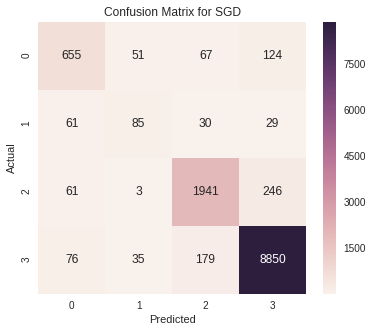

In [220]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predicted = sgd.predict(X_test)
conf_mat = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Confusion Matrix for SGD')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [221]:
from sklearn import metrics

print(metrics.classification_report(y_test, predicted, target_names = df_train_stances['Stance'].unique()))

             precision    recall  f1-score   support

  unrelated       0.77      0.73      0.75       897
      agree       0.49      0.41      0.45       205
   disagree       0.88      0.86      0.87      2251
    discuss       0.96      0.97      0.96      9140

avg / total       0.92      0.92      0.92     12493



# Gradiant Boost

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(verbose=True).fit(X_train, y_train)

print('Accuracy of Gradient Boosting classifier on training set: {:.4f}' .format(logreg.score(X_train, y_train)))
print('Accuracy of Gradient Boosting classifier on test set: {:.4f}' .format(logreg.score(X_test, y_test)))

# MultiLayer Perceptron

In [45]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(verbose=True).fit(X_train, y_train)

Iteration 1, loss = 0.66931392
Iteration 2, loss = 0.47774930
Iteration 3, loss = 0.43698050
Iteration 4, loss = 0.40888575
Iteration 5, loss = 0.38315539
Iteration 6, loss = 0.35924128
Iteration 7, loss = 0.33531526
Iteration 8, loss = 0.31248813
Iteration 9, loss = 0.28911678
Iteration 10, loss = 0.26787853
Iteration 11, loss = 0.24777348
Iteration 12, loss = 0.22825789
Iteration 13, loss = 0.21034291
Iteration 14, loss = 0.19511470
Iteration 15, loss = 0.18136369
Iteration 16, loss = 0.16887260
Iteration 17, loss = 0.15756523
Iteration 18, loss = 0.14687826
Iteration 19, loss = 0.13741148
Iteration 20, loss = 0.12914854
Iteration 21, loss = 0.12138111
Iteration 22, loss = 0.11343920
Iteration 23, loss = 0.10938653
Iteration 24, loss = 0.10193712
Iteration 25, loss = 0.09781504
Iteration 26, loss = 0.09281389
Iteration 27, loss = 0.08924845
Iteration 28, loss = 0.08532757
Iteration 29, loss = 0.08066088
Iteration 30, loss = 0.07783541
Iteration 31, loss = 0.07510243
Iteration 32, los

In [10]:
predicted = clf.predict(X_test[9])
print(predicted)

['unrelated']


In [11]:
print(predicted == y_test[9])

[ True]


In [47]:
print('Accuracy of MLP on training set: {:.4f}' .format(clf.score(X_train, y_train)))
print('Accuracy of MLP on test set: {:.4f}' .format(clf.score(X_test, y_test)))

Accuracy of MLP on training set: 0.9931
Accuracy of MLP on test set: 0.9286


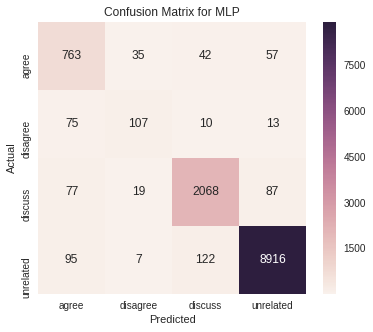

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predicted = clf.predict(X_test)
conf_mat = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['agree', 'disagree', 'discuss', 'unrelated'], yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
plt.title('Confusion Matrix for MLP')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [0]:
from sklearn import metrics

print(metrics.classification_report(y_test, predicted, target_names = df_train_stances['Stance'].unique()))

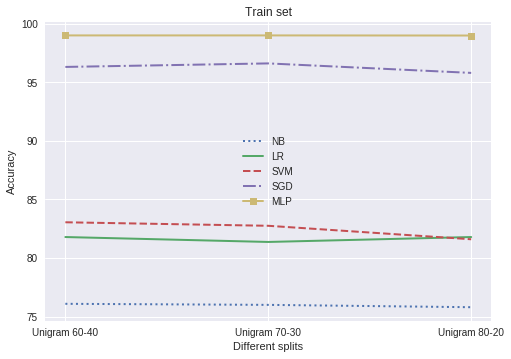

In [1]:
import numpy as np
import matplotlib.pyplot as plt

a = [76.09, 76.00,	75.80]
b = [81.79,	81.37,	81.79]
c = [83.05,	82.75,	81.60]
d = [96.31,	96.61,	95.80]
e = [99,	99,	98.99]

plt.xlabel('Different splits')
plt.ylabel('Accuracy')
plt.title('Train set')
plt.xticks([0,1,2,3],['Unigram 60-40', 'Unigram 70-30', 'Unigram 80-20'])

plt.plot(a, ':', label='NB', linewidth=2)
plt.plot(b, label='LR', linewidth=2)
plt.plot(c, '--', label='SVM', linewidth=2)
plt.plot(d, '-.', label='SGD', linewidth=2)
plt.plot(e, 's-', label='MLP', linewidth=2)
plt.legend()

plt.legend(loc=10)
plt.show()

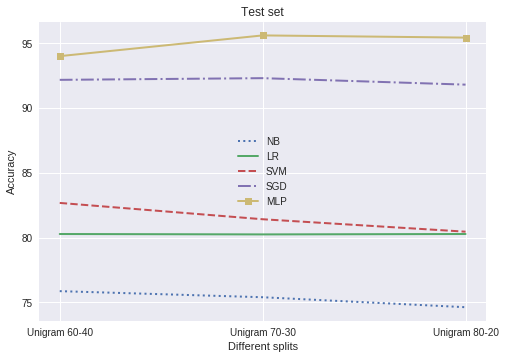

In [1]:
#testing
import numpy as np
import matplotlib.pyplot as plt

a = [75.86, 75.39, 74.62]
b = [80.27, 80.24, 80.27]
c = [82.67, 81.41, 80.45]
d = [92.17, 92.30, 91.80]
e = [94, 95.6, 95.43]

plt.xlabel('Different splits')
plt.ylabel('Accuracy')
plt.title('Test set')
plt.xticks([0,1,2,3],['Unigram 60-40', 'Unigram 70-30', 'Unigram 80-20'])

plt.plot(a, ':', label='NB', linewidth=2)
plt.plot(b, label='LR', linewidth=2)
plt.plot(c, '--', label='SVM', linewidth=2)
plt.plot(d, '-.', label='SGD', linewidth=2)
plt.plot(e, 's-', label='MLP', linewidth=2)
plt.legend()

plt.legend(loc=10)
plt.show()

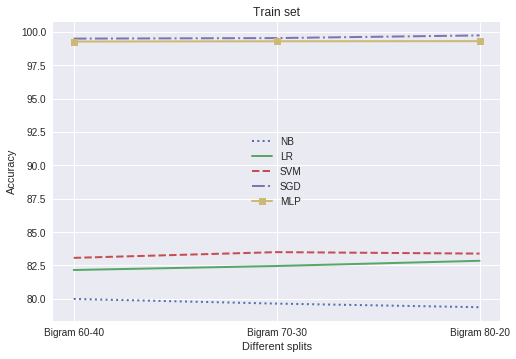

In [4]:
#Bigram Train
import numpy as np
import matplotlib.pyplot as plt

a = [79.99, 79.64, 79.37]
b = [82.16,	82.46, 82.85]
c = [83.07,	83.50, 83.39]
d = [99.51,	99.55, 99.75]
e = [99.29,	99.31, 99.32]

plt.xlabel('Different splits')
plt.ylabel('Accuracy')
plt.title('Train set')
plt.xticks([0,1,2,3],['Bigram 60-40', 'Bigram 70-30', 'Bigram 80-20'])

plt.plot(a, ':', label='NB', linewidth=2)
plt.plot(b, label='LR', linewidth=2)
plt.plot(c, '--', label='SVM', linewidth=2)
plt.plot(d, '-.', label='SGD', linewidth=2)
plt.plot(e, 's-', label='MLP', linewidth=2)
plt.legend()

plt.legend(loc=10)
plt.show()


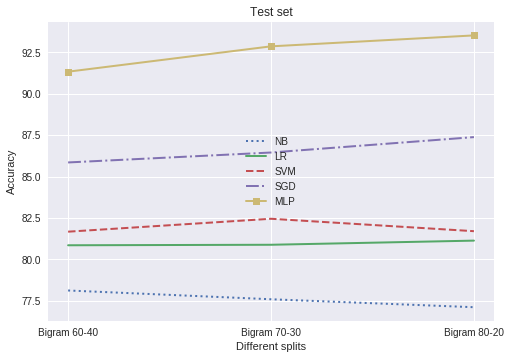

In [3]:
#Bigram Test
import numpy as np
import matplotlib.pyplot as plt

a = [78.12,	77.59, 77.11]
b = [80.85,	80.88, 81.13]
c = [81.67,	82.45, 81.70]
d = [85.85,	86.45, 87.38]
e = [91.33, 92.86, 93.52]

plt.xlabel('Different splits')
plt.ylabel('Accuracy')
plt.title('Test set')
plt.xticks([0,1,2,3],['Bigram 60-40', 'Bigram 70-30', 'Bigram 80-20'])

plt.plot(a, ':', label='NB', linewidth=2)
plt.plot(b, label='LR', linewidth=2)
plt.plot(c, '--', label='SVM', linewidth=2)
plt.plot(d, '-.', label='SGD', linewidth=2)
plt.plot(e, 's-', label='MLP', linewidth=2)
plt.legend()

plt.legend(loc=10)
plt.show()